# Introduction
In this project we are going to analyze 'Brain tumor dataset', a T1 weighted MRI dataset from figshare,
<br>
extract features and create image classification model based on two Convolutional neural network models that predicts both brain tumor type and it's location.
<br><br>
**Contents:**
1) **Data exploration**
    <br>
    1.1 - Image extraction <br>
    1.2 - Splitting Data <br>
    1.3 - Preview images <br>
    1.4 - Black/White balance <br>
    1.5 - Skull size <br>
    1.6 - Class weights <br>
    1.7 - Feature scaling <br><br>
2) **1st Model (tumor type)**
    <br>
    2.1 - Building a model <br>
    2.2 - Visualising results <br>
    2.3 - Testing the model <br><br>
3) **Predicting tumor location**
    <br>
    3.1 - Mask extraction <br>
    3.2 - Splitting Data <br>
    3.3 - Preview the masks <br>
    3.4 - Tumor size <br>
    3.5 - Feature scaling <br><br>
4) **2nd Model (tumor location)**
5) **Conclusion**
<br>

Highly reccomended to read the **data-description.txt** file to understand data organization.<br>
*The code was written in Python 3.12 later changed to 3.10 due to usage of _tensorflow-gpu_.

# I Data exploration
#### 1.1 - Image extraction
The Dataset is in .mat format, so we extract the image values to regular image files.
<br>
For this task we're going to use h2py and cv2 libraries and iterate through mat dataset.
<br><br>
*We don't really need to do that, but I want to show the process as working with regular images.
<br>
Technically we supposed to to assign labels to integer values because later on we'll use loss='sparse_categorical_crossentropy' which is prepared for said value type.
<br><br>
Since we're going to create two different dataset splits, keep in mind that 'train', 'val' and 'test' datasets are for 1st model <br>
while 'train_2', 'val_2' and 'test_2' are prepared for 2nd model. <br>
1st split is by class (tumor type) and second one is by image and mask (tumor location).

In [1]:
import tensorflow as tf
import numpy as np
import os

# set up gpus
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
# print(gpus)
# tf.device('/GPU:0')

# apply stable seed to avoid inconsistent results every time we test new setup
tf.config.experimental.enable_op_determinism()
tf.keras.utils.set_random_seed(0)
tf.random.set_seed(0)
np.random.seed(0)

# define paths for datasets
mat_path = 'D:\\data-science\\brain-tumor-data\\mat'

data_path = 'D:\\data-science\\brain-tumor-data\\images'
data_path_split = data_path + '_split'
mask_path = 'D:\\data-science\\brain-tumor-data\\mask'

path_to_images = os.path.join(mask_path, 'x-image')
path_to_masks = os.path.join(mask_path, 'y-mask')
matrices = os.listdir(mat_path)

In [2]:
import matplotlib.pyplot as plt

# DON'T MIND THIS, it's dark theme for matplotlib
WHITE_MID = '#b5b5b5'
GREY_DARK = '#141414'

plt.rcParams['figure.facecolor'] = GREY_DARK
plt.rcParams['text.color'] = WHITE_MID
plt.rcParams['axes.facecolor'] = GREY_DARK
plt.rcParams['axes.edgecolor'] = WHITE_MID
plt.rcParams['axes.labelcolor'] = WHITE_MID
plt.rcParams['axes.titlecolor'] = WHITE_MID

plt.rcParams['grid.color'] = WHITE_MID
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.grid'] = True

plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.color'] = WHITE_MID
plt.rcParams['ytick.color'] = WHITE_MID
plt.rcParams['legend.edgecolor'] = WHITE_MID
plt.rcParams['legend.labelcolor'] = WHITE_MID

#### 1.2 - Train, val and test split
For this task we use _splitfolders_ library. This makes us sure that data is correctly split without any leaks.
<br><br>
**Ratio:** <br>
train: 70% <br>
val: 20% <br>
test: 10%

In [3]:
train = tf.keras.utils.image_dataset_from_directory(os.path.join(data_path_split, 'train'), batch_size=8, color_mode='grayscale', image_size=(256, 256), label_mode='categorical', shuffle=True, seed=42)
test = tf.keras.utils.image_dataset_from_directory(os.path.join(data_path_split, 'test'), batch_size=8, color_mode='grayscale', image_size=(256, 256), label_mode='categorical', shuffle=True, seed=42)
val = tf.keras.utils.image_dataset_from_directory(os.path.join(data_path_split, 'val'), batch_size=8, color_mode='grayscale', image_size=(256, 256), label_mode='categorical', shuffle=True, seed=42)

data_iterator = test.as_numpy_iterator()
batch = data_iterator.next()

labels = test.class_names
labels

Found 2144 files belonging to 3 classes.
Found 308 files belonging to 3 classes.
Found 612 files belonging to 3 classes.


['glioma', 'meningioma', 'pituitary']

To ensure that there are no leaks that might overfit our model learning process or lead to false accuracy results during testing
<br>
I applied custom function that takes every image from one split and compares it with each image from another split.<br>
The function applies broadcasting. I tested this by copying images between folders by hand. The resulted as predicted (number of duplicates increased for tested directories).

In [4]:
train_images = tf.concat([img for img, label in train], axis=0)
val_images = tf.concat([img for img, label in val], axis=0)
test_images = tf.concat([img for img, label in test], axis=0)

In [5]:
def compare_imgs(data_1, data_2, chunk_size=10):
    nduplicates = 0
    for i in range(0, data_1.shape[0], chunk_size):
        data_1_chunk = data_1[i : i + chunk_size]
        
        # broadcasting
        data_1_chunk_exp = tf.expand_dims(data_1_chunk, axis=1)
        data_2_exp = tf.expand_dims(data_2, axis=0)
        
        # Compare
        equality_matrix = tf.reduce_all(data_1_chunk_exp == data_2_exp, axis=[2, 3])
        
        # Count duplicates in the chunk
        nduplicates += tf.reduce_sum(tf.cast(tf.reduce_any(equality_matrix, axis=-1), tf.int32))

    return nduplicates

In [6]:
count = compare_imgs(train_images, val_images)
print(f"There are {count} data leaks between train and val splits.")

count = compare_imgs(train_images, test_images)
print(f"There are {count} data leaks between train and test splits.")

count = compare_imgs(val_images, test_images)
print(f"There are {count} data leaks between val and test splits.")

count = compare_imgs(test_images, test_images)
print(f"There are {count} data leaks between test and test splits.")

There are 0 data leaks between train and val splits.
There are 0 data leaks between train and test splits.
There are 0 data leaks between val and test splits.
There are 308 data leaks between test and test splits.


#### 1.3 - Preview the images
Data iterator allows us to move through data and preview it more swiftly.

   batches: 8
     width: 256
    height: 256
  channels: 1


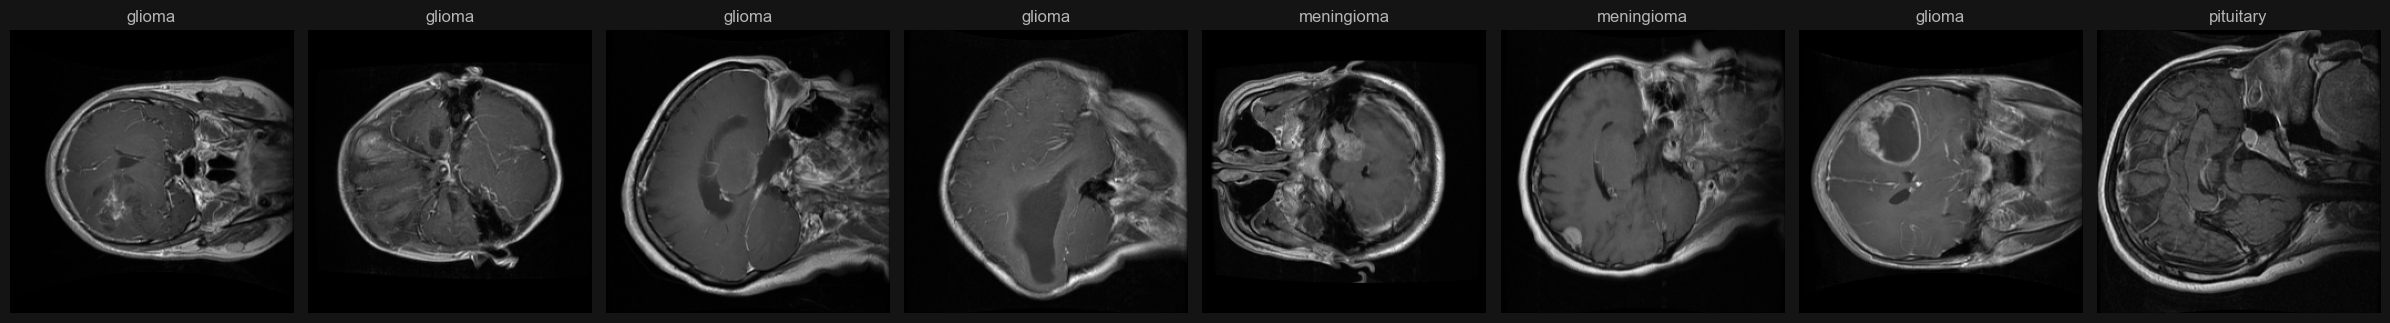

In [7]:
import seaborn as sb

fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(24, 6))
for i, img in enumerate(batch[0][:8]):
    class_name = labels[np.argmax(batch[-1][i])]
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(class_name)
    axes[i].set_axis_off()

for key, value in zip(['batches', 'width', 'height', 'channels'], batch[0].shape):
    print(f"{key:>10}: {value}")

plt.tight_layout()
plt.show()

Our dataset contains 512px x 512px images and each pixel has 3 channels so basically each image contains **786 432** values,
<br>
with *color_mode = 'grayscale'* we reduce it to **262 144**. Also keras resized our files to size of 256px x 256px so we end up with **65 536** values per image.

#### 1.4 - Black/white balance
Every point on the plot is a single image, we can note that most of images hang around 70.<br>
Note that we skip black background. We just want to check mean color of head area.

          Mean: 70.33614349365234
 Harmonic mean: 68.72393664459248


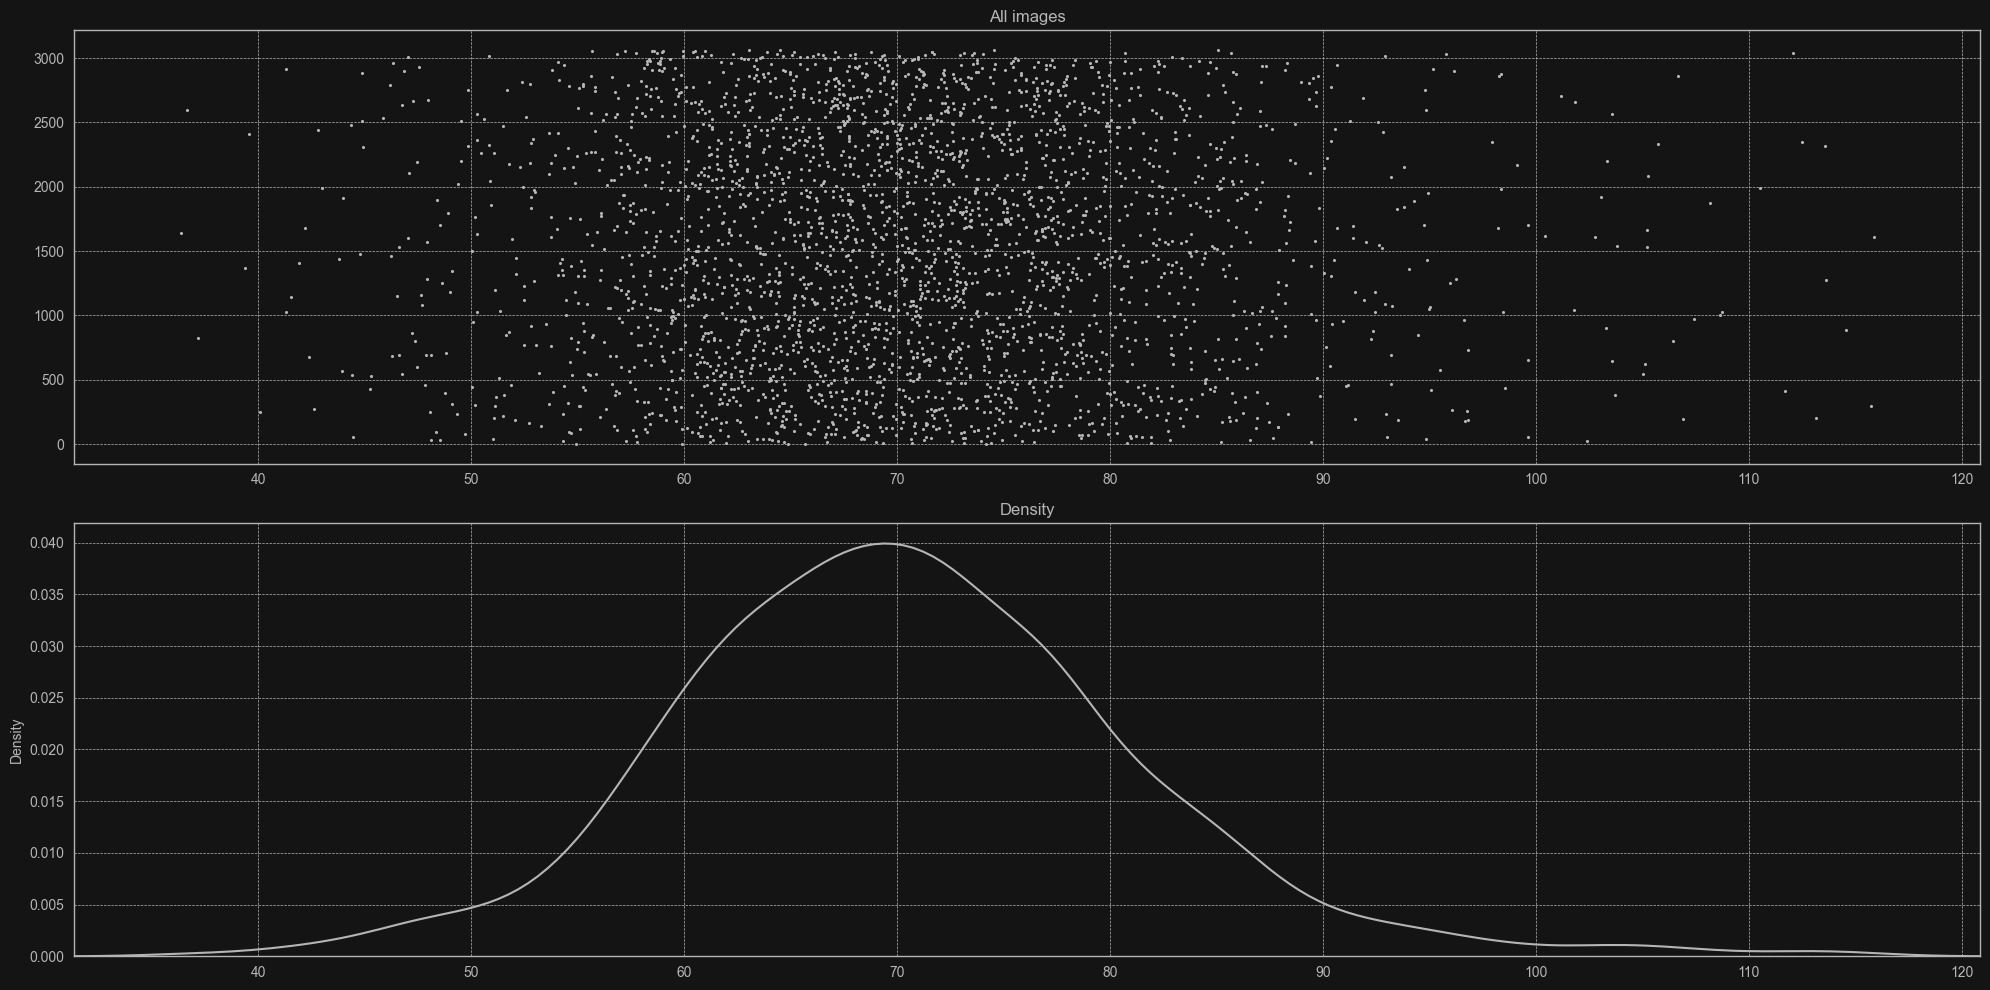

In [123]:
from scipy.stats.mstats import hmean

# skipping values to 10 because it's background and it will lower our mean
all_images = np.concatenate([train_images, val_images, test_images], axis=0)
all_means = [np.mean(x[x > 10]) for x in all_images]

print(f'{"Mean":>14}: {np.mean(all_means)}\n'
      f'{"Harmonic mean":>14}: {hmean(all_means)}')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
sb.scatterplot(y=[x for x in range(len(all_means))], x=all_means, color=WHITE_MID, s=20, ax=axes[0], marker='.', linewidth=0)
sb.kdeplot(x=all_means, ax=axes[1], color=WHITE_MID)

padding = (min(all_means) - 5, max(all_means) + 5)
axes[0].set_xlim(padding)
axes[0].set_title('All images')
axes[1].set_xlim(padding)
axes[1].set_title('Density')
plt.tight_layout()

#### 1.5 Head area
By calculating amount of white pixels inside image we can extract images with specific skull/head area.
<br>
__*threshold*__ is max value that we consider/define as black background. The more the noisy our background is the higher the threshold we apply.
<br>
<br>
In summary this plot returns images where head fills specified % (see percentage variable) of area in image.
<br>


There are 18 image/s with head pixels filling less than 25%.


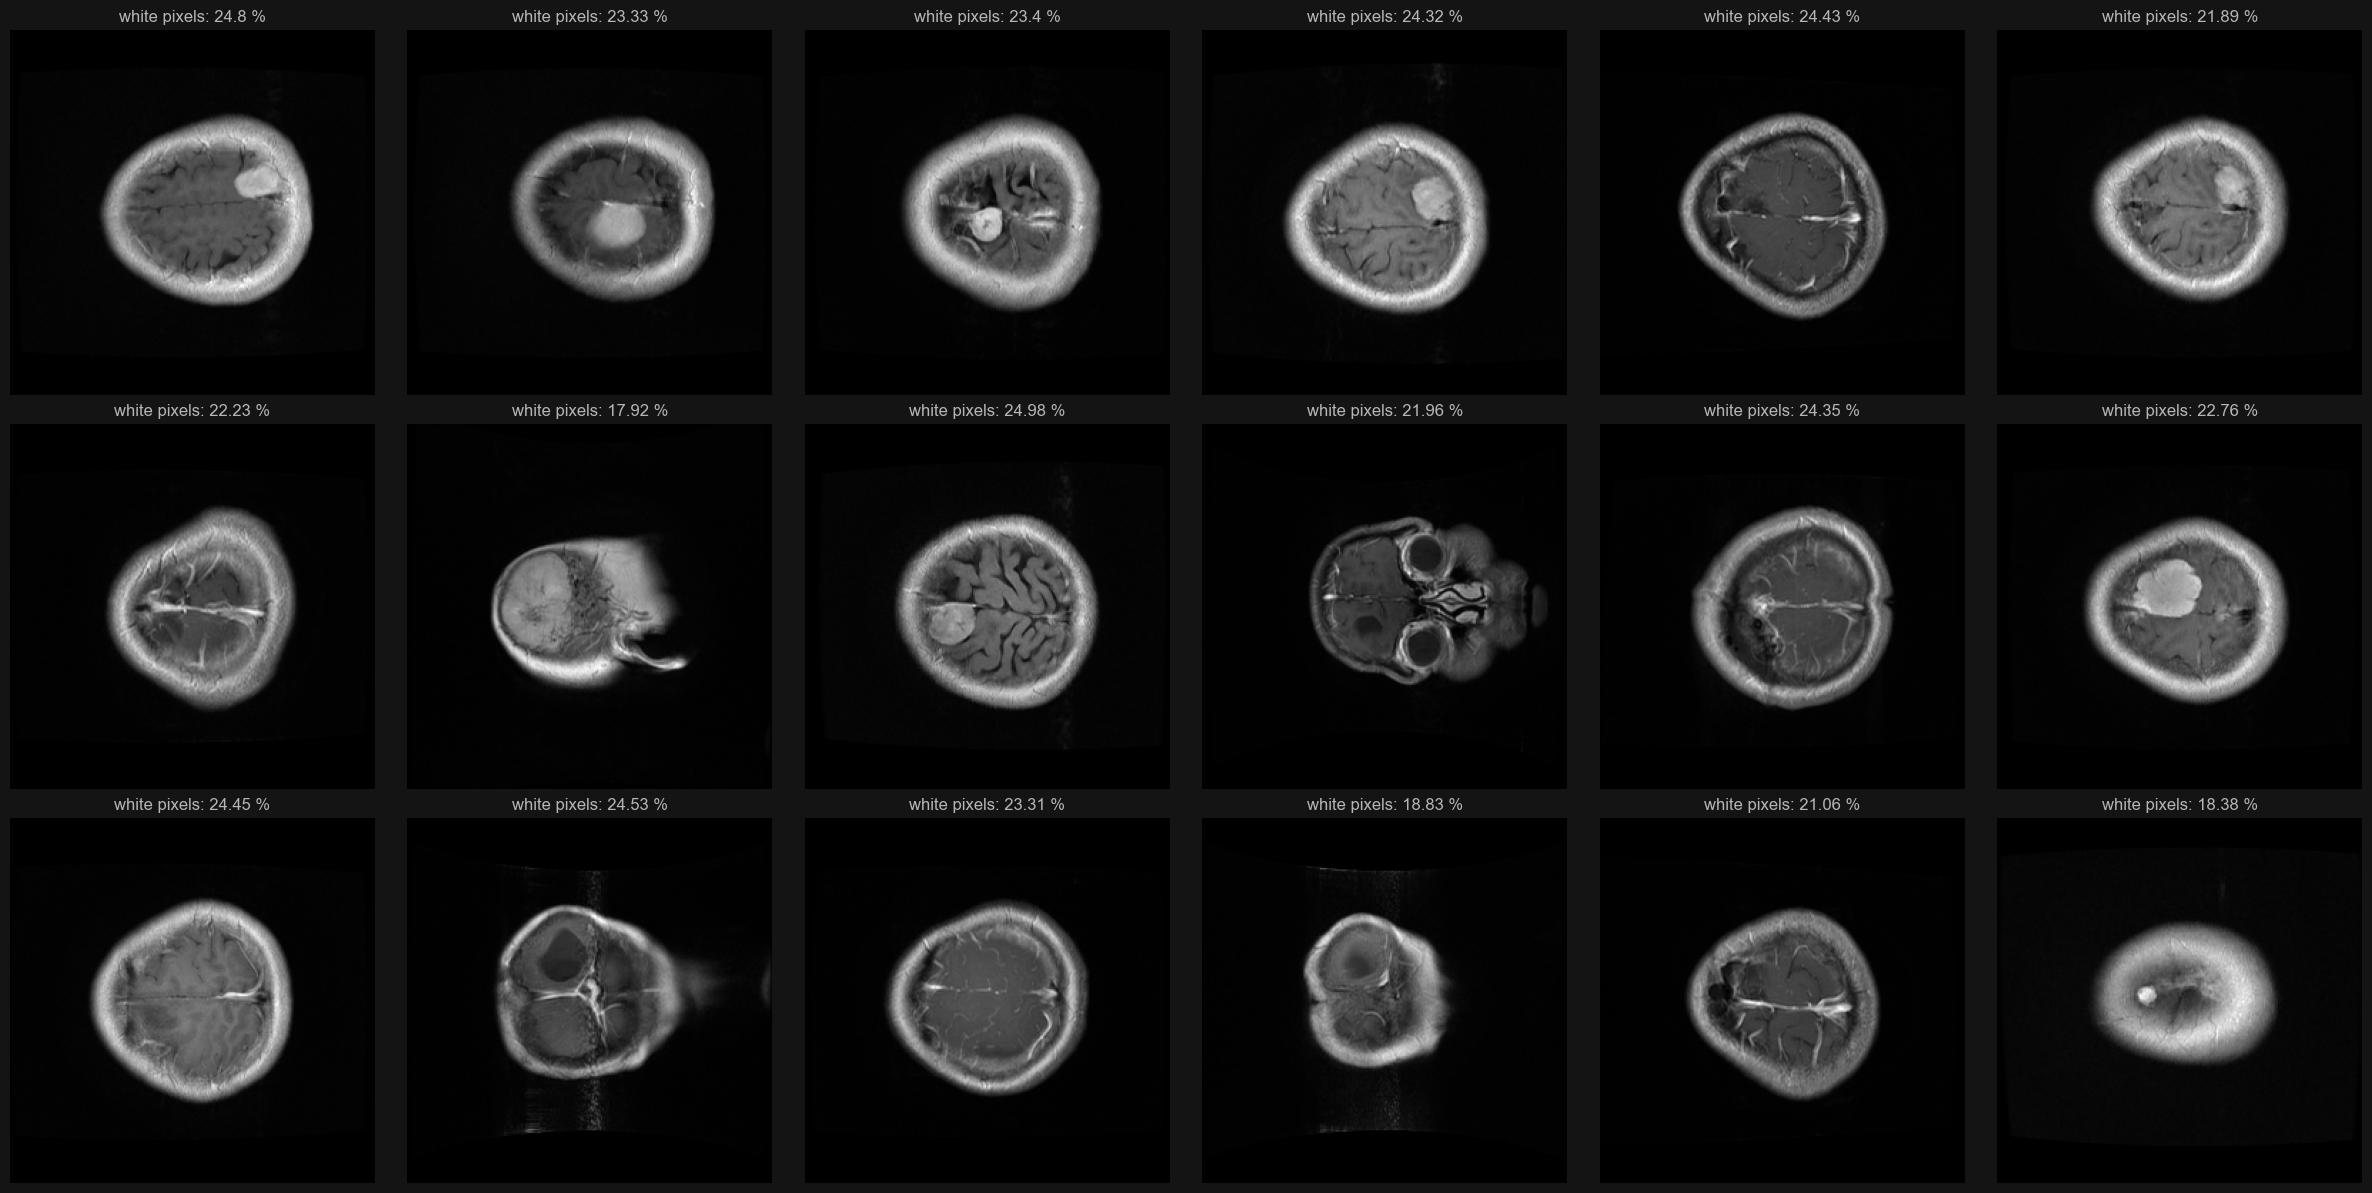

In [124]:
threshold = 10
percentage = 25

head_pixels = []

# sub plot created for 18 images, I checked the amount before
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24, 12))
axes = axes.flatten()

small_head = 0
i = 0
for img in all_images:
    n_white_pixels = np.sum(img > threshold)
    percentage_white_pixels = (n_white_pixels / (256*256)) * 100
    head_pixels.append(percentage_white_pixels)
    
    if percentage_white_pixels < percentage:
        if i < 18:
            small_head += 1
            axes[i].set_title(f"white pixels: {round(percentage_white_pixels, 2)} %")
            axes[i].set_axis_off()
            axes[i].imshow(img, cmap='gray')
            i += 1

print(f"There are {small_head} image/s with head pixels filling less than {percentage}%.")
plt.tight_layout()

This allow us to categorize images based on skull area.

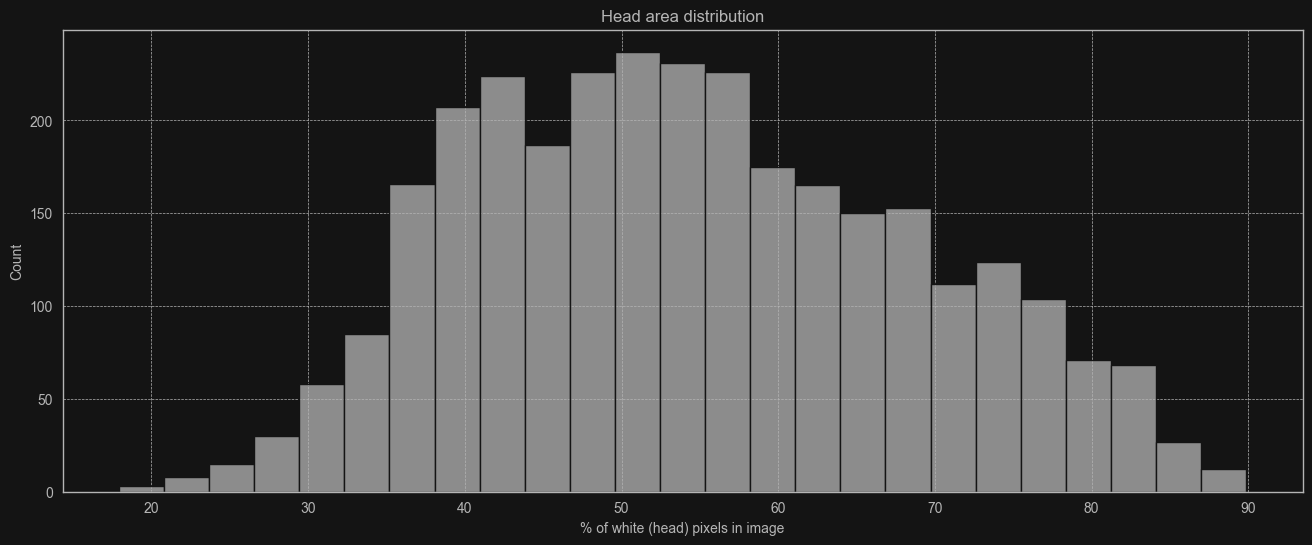

In [12]:
plt.figure(figsize=(16, 6))

sb.histplot(data=head_pixels, color=WHITE_MID, linewidth=1, edgecolor=GREY_DARK)
plt.title('Head area distribution')
plt.xlabel('% of white (head) pixels in image')
plt.show()

#### 1.6 - Class weights

Class        Count
glioma     : 1426
meningioma : 708
pituitary  : 930


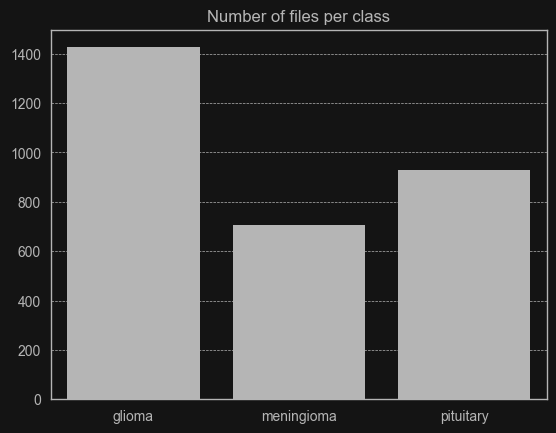

In [13]:
files_per_label = lambda folder: os.listdir(os.path.join(data_path, folder))

# generate dictionary with lengths for each label
labels_len = {label: len(files_per_label(label)) for i, label in enumerate(labels)}

sb.barplot(data=labels_len, x=labels_len.keys(), y=labels_len.values(), color=WHITE_MID, linewidth=0)

print(f"{'Class':<10}   Count")
for label, count in labels_len.items():
    print(f"{label:<10} : {count}")

plt.title('Number of files per class')
plt.show()

To handle class imbalance, we can calculate weights with given formula:
<br><br>
$w_c = \frac{N}{N_c * C}$
<br><br>
where:
<br>
$ w_c $ = class weight <br>
$ N $ = number of samples in dataset <br>
$ N_c $ = number of samples in class <br>
$ C $ = number of unique classes in dataset

In [37]:
class_weights = dict()

for i, count in enumerate(labels_len.values()):
    class_weights[i] = round(sum(labels_len.values()) / (len(labels) * count), 1)

print(f"{'Class':<10}   Weight")
for i, weight in class_weights.items():
    print(f"{labels[i]:<10} : {weight}")

Class        Weight
glioma     : 0.7
meningioma : 1.4
pituitary  : 1.1


#### 1.7 - Feature scaling
Usually when we work with Images, the max value is 255 so we're going to transform our values from [min, max] = [0, 255] to [0, 1].

In [15]:
print(batch[0].min(), batch[0].max(), sep='\n')

0.0
249.75


In [16]:
train = train.map(lambda x, y: (x/255, y))
test = test.map(lambda x, y: (x/255, y))
val = val.map(lambda x, y: (x/255, y))

iterator = test.as_numpy_iterator()
batch = iterator.next()

min_value = iterator.next()[0].min()
max_value = iterator.next()[0].max()

print(min_value, max_value, sep='\n')

0.0
0.99313724


# II 1st Model
#### 2.1 - Building a neural network
In short our model base on convolutional layers, where each layer contain filter that convolve with input matrix (image) resulting filtered output.
<br>
As input shape we apply values that corresponds to:
- width = 256
- height = 256
- channel = 1 (grayscale).
<br>

__*ReLU*__ activation function cleans our output from all unnecessary negative values, replacing them with zeros.
<br>
__*Dropout*__ layers drops random neurons each time convolution layer is being applied, reducing chance to overfit.

In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input, ReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [100]:
def create_model(kernel_size=3, learning_rate=0, regulate=0, slope=0):
    
    model = Sequential()
    
    model.add(Input(shape=(256, 256, 1)))
    
    for num_filters in [16, 32, 16]:
        model.add(Conv2D(num_filters, (kernel_size, kernel_size), stride=1, activation='relu'))
        model.add(Dropout(0.3))
        model.add(MaxPooling2D())
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model

In [117]:
model = create_model(learning_rate=0.0005)
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 254, 254, 16)      160       
                                                                 
 dropout_51 (Dropout)        (None, 254, 254, 16)      0         
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 dropout_52 (Dropout)        (None, 125, 125, 32)      0         
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                

In [118]:
n_epochs = 20

model_checkpoint = ModelCheckpoint(
    'best_model_1.h5',
    monitor='val_categorical_accuracy',
    
    save_best_only=True,
    restore_best_weights=True,
    verbose=0
)

In [119]:
hist = model.fit(train, validation_data=val, epochs=n_epochs, class_weight=class_weights, callbacks=[model_checkpoint])

Epoch 1/20
268/268 [==============================] - 7s 22ms/step - loss: 0.6757 - categorical_accuracy: 0.6604 - val_loss: 0.5687 - val_categorical_accuracy: 0.7337
Epoch 2/20
268/268 [==============================] - 6s 21ms/step - loss: 0.4001 - categorical_accuracy: 0.8223 - val_loss: 0.4343 - val_categorical_accuracy: 0.8824
Epoch 3/20
268/268 [==============================] - 6s 21ms/step - loss: 0.2592 - categorical_accuracy: 0.8909 - val_loss: 0.3510 - val_categorical_accuracy: 0.8954
Epoch 4/20
268/268 [==============================] - 6s 21ms/step - loss: 0.1895 - categorical_accuracy: 0.9123 - val_loss: 0.2822 - val_categorical_accuracy: 0.9085
Epoch 5/20
268/268 [==============================] - 6s 21ms/step - loss: 0.1508 - categorical_accuracy: 0.9394 - val_loss: 0.2891 - val_categorical_accuracy: 0.9216
Epoch 6/20
268/268 [==============================] - 6s 21ms/step - loss: 0.1190 - categorical_accuracy: 0.9534 - val_loss: 0.2571 - val_categorical_accuracy: 0.910

#### 2.2 - Visualising results
I split it to 4 different plots where green line is the best epoch.

0.16467131674289703
0.9460784196853638


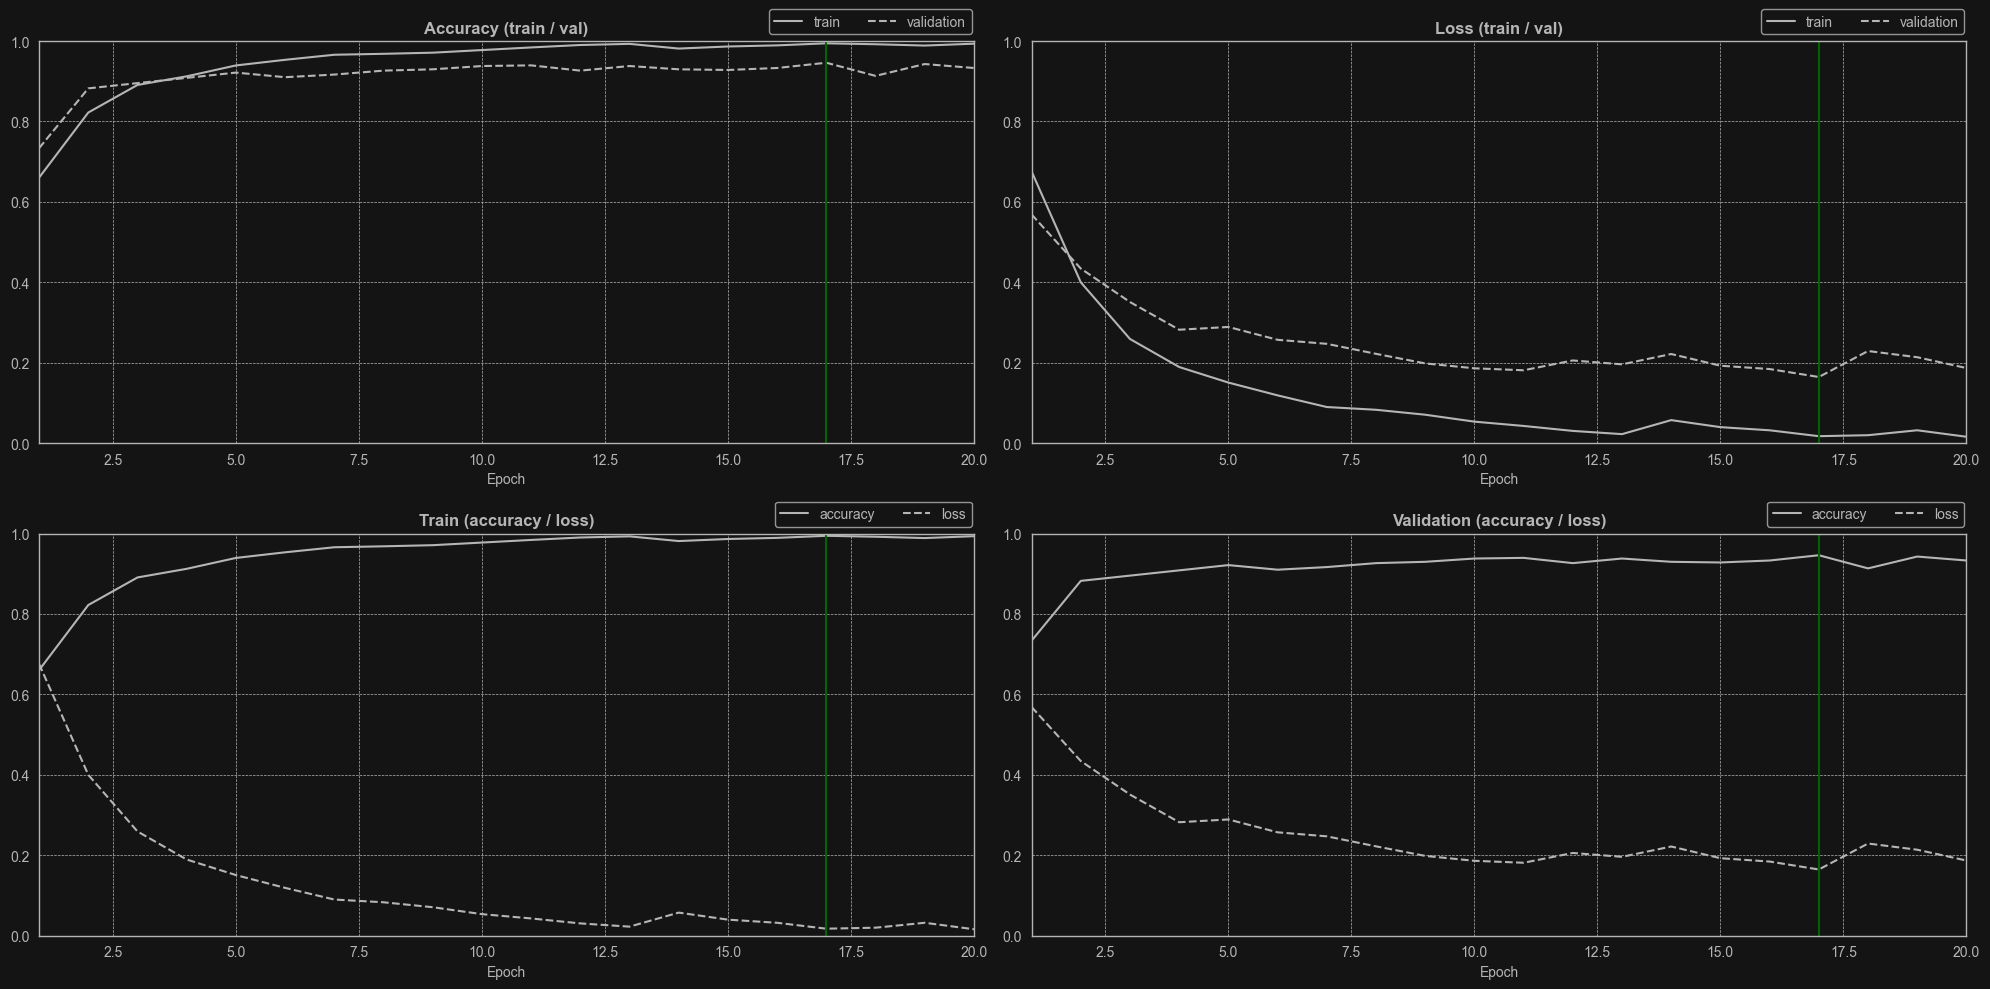

In [120]:
acc_labels = list(hist.history.keys())
best_epoch = hist.history['val_loss'].index(min(hist.history['val_loss']))
print(hist.history['val_loss'][best_epoch],
      hist.history['val_categorical_accuracy'][best_epoch],
      sep='\n'
)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
axes = axes.flatten()

sb.lineplot(data=hist.history, y='categorical_accuracy', x=[x for x in range(1, n_epochs+1, 1)], label='train', ax=axes[0], color=WHITE_MID)
sb.lineplot(data=hist.history, y='val_categorical_accuracy', x=[x for x in range(1, n_epochs+1, 1)], label='validation', ax=axes[0], linestyle='--', color=WHITE_MID)

sb.lineplot(data=hist.history, y='loss', x=[x for x in range(1, n_epochs+1, 1)], label='train', ax=axes[1], color=WHITE_MID)
sb.lineplot(data=hist.history, y='val_loss', x=[x for x in range(1, n_epochs+1, 1)], label='validation', ax=axes[1], linestyle='--', color=WHITE_MID)

sb.lineplot(data=hist.history, y='categorical_accuracy', x=[x for x in range(1, n_epochs+1, 1)], label='accuracy', ax=axes[2], color=WHITE_MID)
sb.lineplot(data=hist.history, y='loss', x=[x for x in range(1, n_epochs+1, 1)], label='loss', ax=axes[2], linestyle='--', color=WHITE_MID)

sb.lineplot(data=hist.history, y='val_categorical_accuracy', x=[x for x in range(1, n_epochs+1, 1)], label='accuracy', ax=axes[3], color=WHITE_MID)
sb.lineplot(data=hist.history, y='val_loss', x=[x for x in range(1, n_epochs+1, 1)], label='loss', ax=axes[3], linestyle='--', color=WHITE_MID)

for i in range(4):
    axes[i].legend(loc='lower right', bbox_to_anchor=(1.005, 1), ncol=2)
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylim([0, 1])
    axes[i].set_xlim([1, n_epochs])
    axes[i].set_ylabel('')
    axes[i].axvline(x=best_epoch+1, color='darkgreen')

axes[0].set_title('Accuracy (train / val)', weight='bold')
axes[1].set_title('Loss (train / val)', weight='bold')
axes[2].set_title('Train (accuracy / loss)', weight='bold')
axes[3].set_title('Validation (accuracy / loss)', weight='bold')

plt.tight_layout()

#### 2.3 - Testing the model
Both Training and Validation curves looks very promising, however we have to test our model for final results.

In [125]:
y_true = []
y_pred = []

for batch_images, batch_labels in test:
    y_true_batch = np.argmax(batch_labels, axis=1)
    y_pred_batch = np.argmax(model.predict(batch_images, verbose=0), axis=1)

    y_true.extend(y_true_batch)
    y_pred.extend(y_pred_batch)
    
y_true = np.array(y_true)
y_pred = np.array(y_pred)

              precision    recall  f1-score   support

      glioma       0.93      0.97      0.95       143
  meningioma       0.92      0.83      0.88        72
   pituitary       0.97      0.97      0.97        93

    accuracy                           0.94       308
   macro avg       0.94      0.92      0.93       308
weighted avg       0.94      0.94      0.94       308



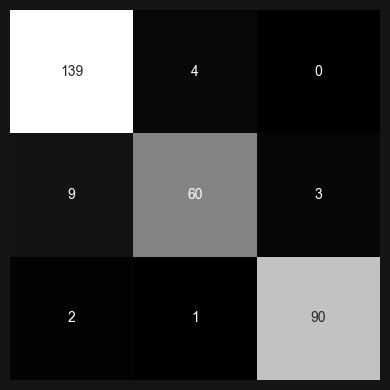

In [126]:
from sklearn.metrics import classification_report, confusion_matrix

report = classification_report(y_true, y_pred, target_names=labels)
print(report)

cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
fig = plt.figure(figsize=(4, 4))
fig = sb.heatmap(cm, annot=True, fmt='d', cbar=False, cmap='Greys_r', linewidths=0)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.axis('off')
plt.tight_layout()

# III Finding tumor location
First we prepare the file paths to our images and masks that we extracted before.

In [127]:
print(path_to_images, path_to_masks, sep='\n')

D:\data-science\brain-tumor-data\mask\x-image
D:\data-science\brain-tumor-data\mask\y-mask


In [128]:
input_img_paths = sorted(
    [
        os.path.join(path_to_images, fname)
        for fname in os.listdir(path_to_images)
        if fname.endswith(".png")
    ]
)
mask_img_paths = sorted(
    [
        os.path.join(path_to_masks, fname)
        for fname in os.listdir(path_to_masks)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

Checking name pairing with shuffled paths for extra accuracy.

In [129]:
import random
random.Random(0).shuffle(input_img_paths)
random.Random(0).shuffle(mask_img_paths)

In [130]:
count = 0
for nth_img_path, nth_mask_path in zip(input_img_paths, mask_img_paths):
    img_id = os.path.basename(nth_img_path)[:4]
    mask_id = os.path.basename(nth_mask_path)[:4]
    if img_id != mask_id:
        count += 1

print(f"Misaligned file names: {count}")
len(input_img_paths) == len(mask_img_paths)

Misaligned file names: 0


True

Function for generating dataset.

In [131]:
def get_dataset(
        batch_size,
        img_size,
        X_files,
        y_files,
):
    """Returns a TF Dataset."""
    
    def load_img_masks(nth_img_path, nth_mask_path):
        input_img = tf.io.read_file(nth_img_path)
        input_img = tf.io.decode_png(input_img, channels=1)
        input_img = tf.image.resize(input_img, img_size)
        input_img = tf.image.convert_image_dtype(input_img, "float32")
        
        mask_img = tf.io.read_file(nth_mask_path)
        mask_img = tf.io.decode_png(mask_img, channels=1)
        mask_img = tf.image.resize(mask_img, img_size, method="nearest")
        mask_img = tf.image.convert_image_dtype(mask_img, "uint8")
        
        return input_img, mask_img
    
    dataset = tf.data.Dataset.from_tensor_slices((X_files, y_files))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(batch_size)

In [132]:
train_nsamples = round((3064 * 0.7))
val_nsamples = round((3064 * 0.2))
test_nsamples = round((3064 * 0.1))
print(train_nsamples, val_nsamples, test_nsamples)
sum([train_nsamples, val_nsamples, test_nsamples]) == len(input_img_paths)

2145 613 306


True

#### 3.2 Splitting Data
For X we apply original images and for y, the masks.

In [133]:
X_train_files = input_img_paths[:train_nsamples]
y_train_files = mask_img_paths[:train_nsamples]

X_val_files = input_img_paths[train_nsamples:(train_nsamples + val_nsamples)]
y_val_files = mask_img_paths[train_nsamples:(train_nsamples + val_nsamples)]

X_test_files = input_img_paths[-test_nsamples:]
y_test_files = mask_img_paths[-test_nsamples:]

train_2 = get_dataset(
    8,
    (256, 256),
    X_train_files,
    y_train_files
)

val_2 = get_dataset(
    8,
    (256, 256),
    X_val_files,
    y_val_files
)

test_2 = get_dataset(
    8,
    (256, 256),
    X_test_files,
    y_test_files
)

In [134]:
# checks if the files inside split are unique (no duplicates)
train_files_ids = set(X_train_files)
print(len(train_files_ids) == train_nsamples)

val_files_ids = set(X_val_files)
print(len(val_files_ids) == val_nsamples)

test_files_ids = set(X_test_files)
print(len(test_files_ids) == test_nsamples)

# this should return 3x False for proving there's no leaks between splits
print(bool(train_files_ids.intersection(val_files_ids)))
print(bool(train_files_ids.intersection(test_files_ids)))
print(bool(test_files_ids.intersection(val_files_ids)))

True
True
True
False
False
False


#### 3.3 - Preview the masks

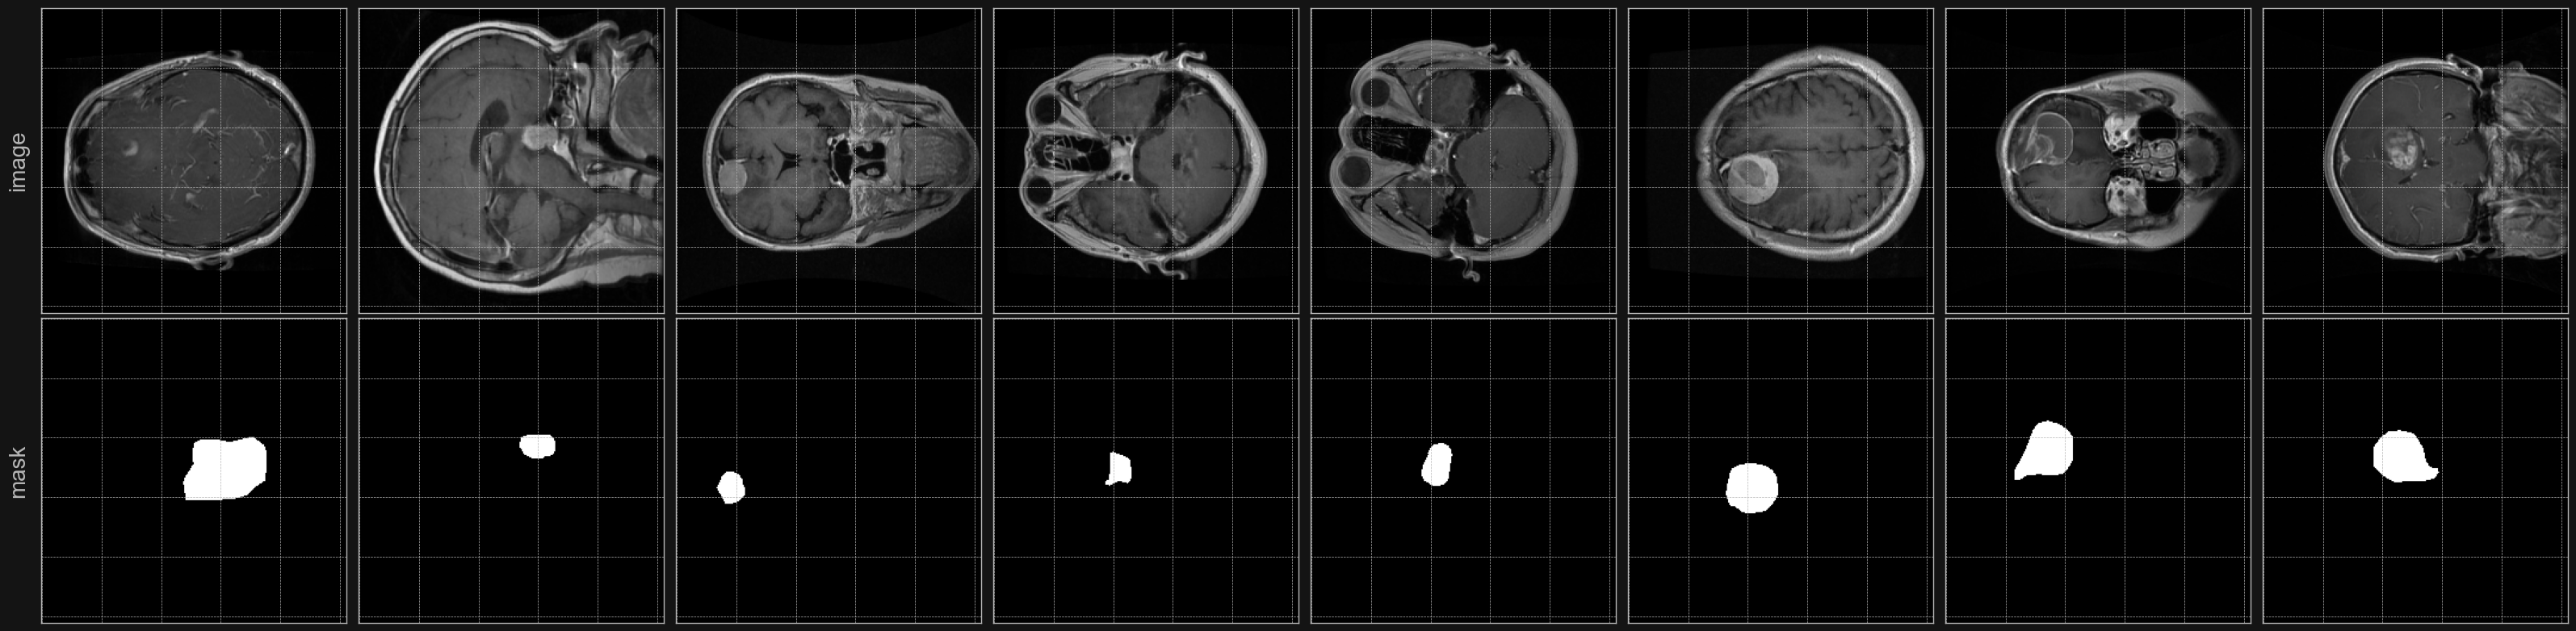

In [135]:
nth_batch = random.randint(0, 10)

fig, axes = plt.subplots(2, 8, figsize=(32, 8))
axes = axes.flatten()
        
axes[0].set_ylabel('image', size=20)
axes[8].set_ylabel('mask', size=20)

for img, mask in test_2.take(nth_batch):
    for i in range(8):
        axes[i].imshow(img[i], cmap='grey')
        axes[i].set_xticklabels([])
        axes[i].set_yticklabels([])
        
        axes[i+8].imshow(mask[i], cmap='grey')
        axes[i+8].set_xticklabels([])
        axes[i+8].set_yticklabels([])

plt.tight_layout()

#### 3.4 Tumor area
This step is similar to _head area_ step. But this time we calculate the amount of white pixels inside **mask** images.

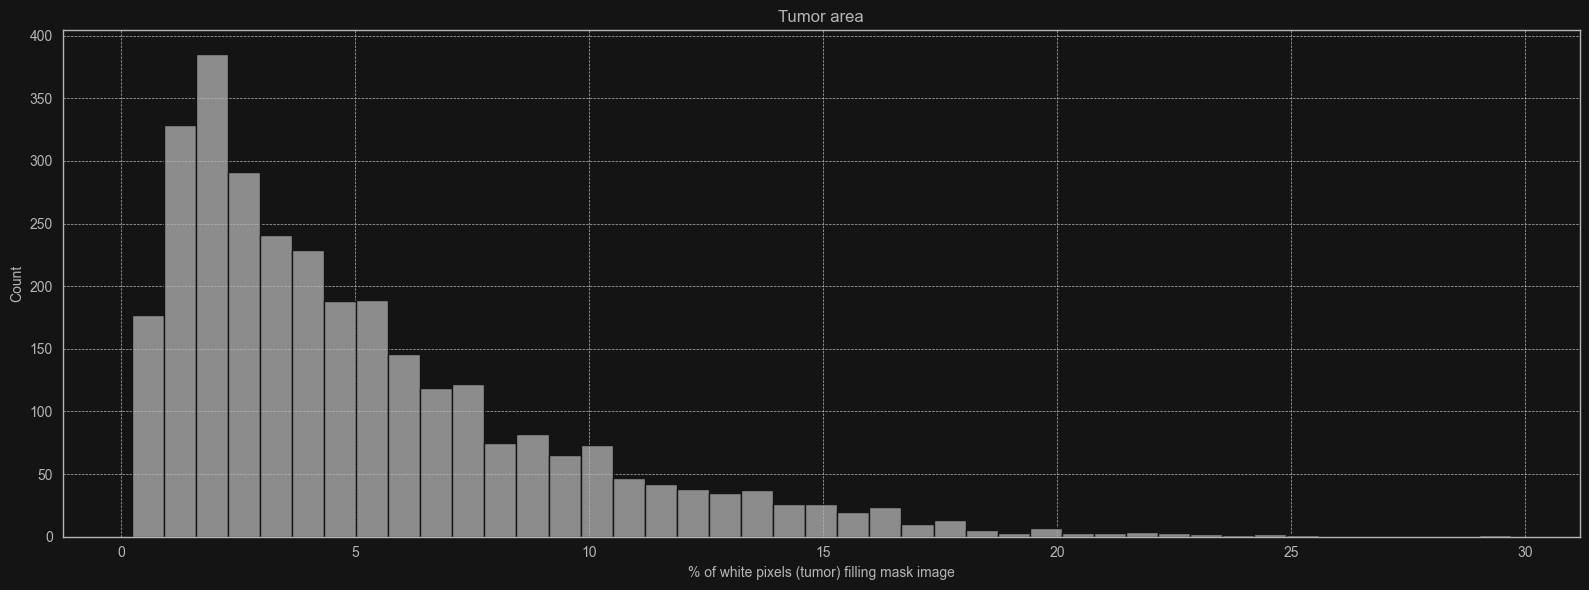

In [139]:
import cv2 as cv

y_all = np.concatenate((y_train_files, y_val_files, y_test_files))
tumor_pixels = []

for nth_mask_path in y_all:
    mask = cv.imread(nth_mask_path)
    
    n_white_pixels = np.sum(mask == 255)
    percentage_white_pixels = (n_white_pixels / (512*512)) * 100
    tumor_pixels.append(percentage_white_pixels)

plt.figure(figsize=(16, 6))
sb.histplot(data=tumor_pixels, color=WHITE_MID, linewidth=1, edgecolor=GREY_DARK)
plt.title('Tumor area')
plt.xlabel('% of white pixels (tumor) filling mask image')
plt.tight_layout()

#### 3.5 - Feature scaling

In [140]:
batch_sample = train_2.take(1)

for img, mask in batch_sample:
    print(
        f"min: {img[0].numpy().min()},",
        f"max: {img[0].numpy().max()}",
    )

min: 0.0, max: 215.75


In [141]:
train_2 = train_2.map(lambda x, y: (x/255, y/255))
val_2 = val_2.map(lambda x, y: (x/255, y/255))
test_2 = test_2.map(lambda x, y: (x/255, y/255))

In [142]:
batch_sample = train_2.take(1)

for img, mask in batch_sample:
    print(
        f"min: {img[0].numpy().min()},",
        f"max: {img[0].numpy().max()}",
    )

min: 0.0, max: 0.8460784554481506


# IV 2nd Model
#### 4.1 - Building neural network
In first model we used standard convolutional neural network. This time we're also going to use CNN but with U-Net arichtecture. <br>
Also, instead of using Sequential API, we use Functional API, which allows the model to share its layers between the encoder and decoder.

In [161]:
from keras import layers, Model
from keras.metrics import BinaryAccuracy

def create_unet_model(learning_rate=0.0001):

    # INPUT
    inputs = Input(shape=(256, 256, 1))
    x = layers.Conv2D(16, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # ENCODER
    for filters in [32, 64, 128]:
        x = layers.SeparableConv2D(filters, 3, padding="same", activation='relu')(x)
        x = layers.BatchNormalization()(x)

        x = layers.SeparableConv2D(filters, 3, padding="same", activation='relu')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # DECODER
    for filters in [128, 64, 32, 16]:
        x = layers.Conv2DTranspose(filters, 3, padding="same", activation='relu')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Conv2DTranspose(filters, 3, padding="same", activation='relu')(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2, interpolation="bilinear")(x)

    outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)

    # define and compile
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate), loss="binary_crossentropy", metrics=BinaryAccuracy())
    return model

In [162]:
u_net = create_unet_model(learning_rate=0.0005)
u_net.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_54 (Conv2D)          (None, 128, 128, 16)      160       
                                                                 
 batch_normalization_60 (Bat  (None, 128, 128, 16)     64        
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 128, 128, 16)      0         
                                                                 
 separable_conv2d_24 (Separa  (None, 128, 128, 32)     688       
 bleConv2D)                                                      
                                                                 
 batch_normalization_61 (Bat  (None, 128, 128, 32)     128 

In [165]:
n_epochs = 5

model_checkpoint_2 = ModelCheckpoint(
    'best_model_2.h5',
    monitor='val_loss',

    save_best_only=True,
    restore_best_weights=True,
    verbose=0
)

In [166]:
hist_unet = u_net.fit(train_2, validation_data=val_2, epochs=n_epochs, callbacks=[model_checkpoint_2])

Epoch 1/10
269/269 [==============================] - 19s 68ms/step - loss: 0.0225 - binary_accuracy: 0.9918 - val_loss: 0.0395 - val_binary_accuracy: 0.9860
Epoch 2/10
269/269 [==============================] - 18s 67ms/step - loss: 0.0204 - binary_accuracy: 0.9924 - val_loss: 0.0327 - val_binary_accuracy: 0.9888
Epoch 3/10
269/269 [==============================] - 18s 66ms/step - loss: 0.0179 - binary_accuracy: 0.9932 - val_loss: 0.0359 - val_binary_accuracy: 0.9874
Epoch 4/10
269/269 [==============================] - 18s 67ms/step - loss: 0.0161 - binary_accuracy: 0.9938 - val_loss: 0.0382 - val_binary_accuracy: 0.9889
Epoch 5/10
269/269 [==============================] - 18s 66ms/step - loss: 0.0151 - binary_accuracy: 0.9941 - val_loss: 0.0355 - val_binary_accuracy: 0.9885
Epoch 6/10
269/269 [==============================] - 18s 67ms/step - loss: 0.0142 - binary_accuracy: 0.9944 - val_loss: 0.0595 - val_binary_accuracy: 0.9873
Epoch 7/10
269/269 [==============================] 

#### 4.2 - Testing the U-Net model

In [168]:
y_true = []
y_pred = []
x_true = []

for image_batch, mask_batch in test_2:
    y_true_batch = mask_batch
    y_pred_batch = u_net.predict(image_batch, verbose=0)
    
    y_true.extend(y_true_batch)
    y_pred.extend(y_pred_batch)
    x_true.extend(image_batch)
    
y_true = np.array(y_true)
y_pred = np.array(y_pred)
x_true = np.array(x_true)

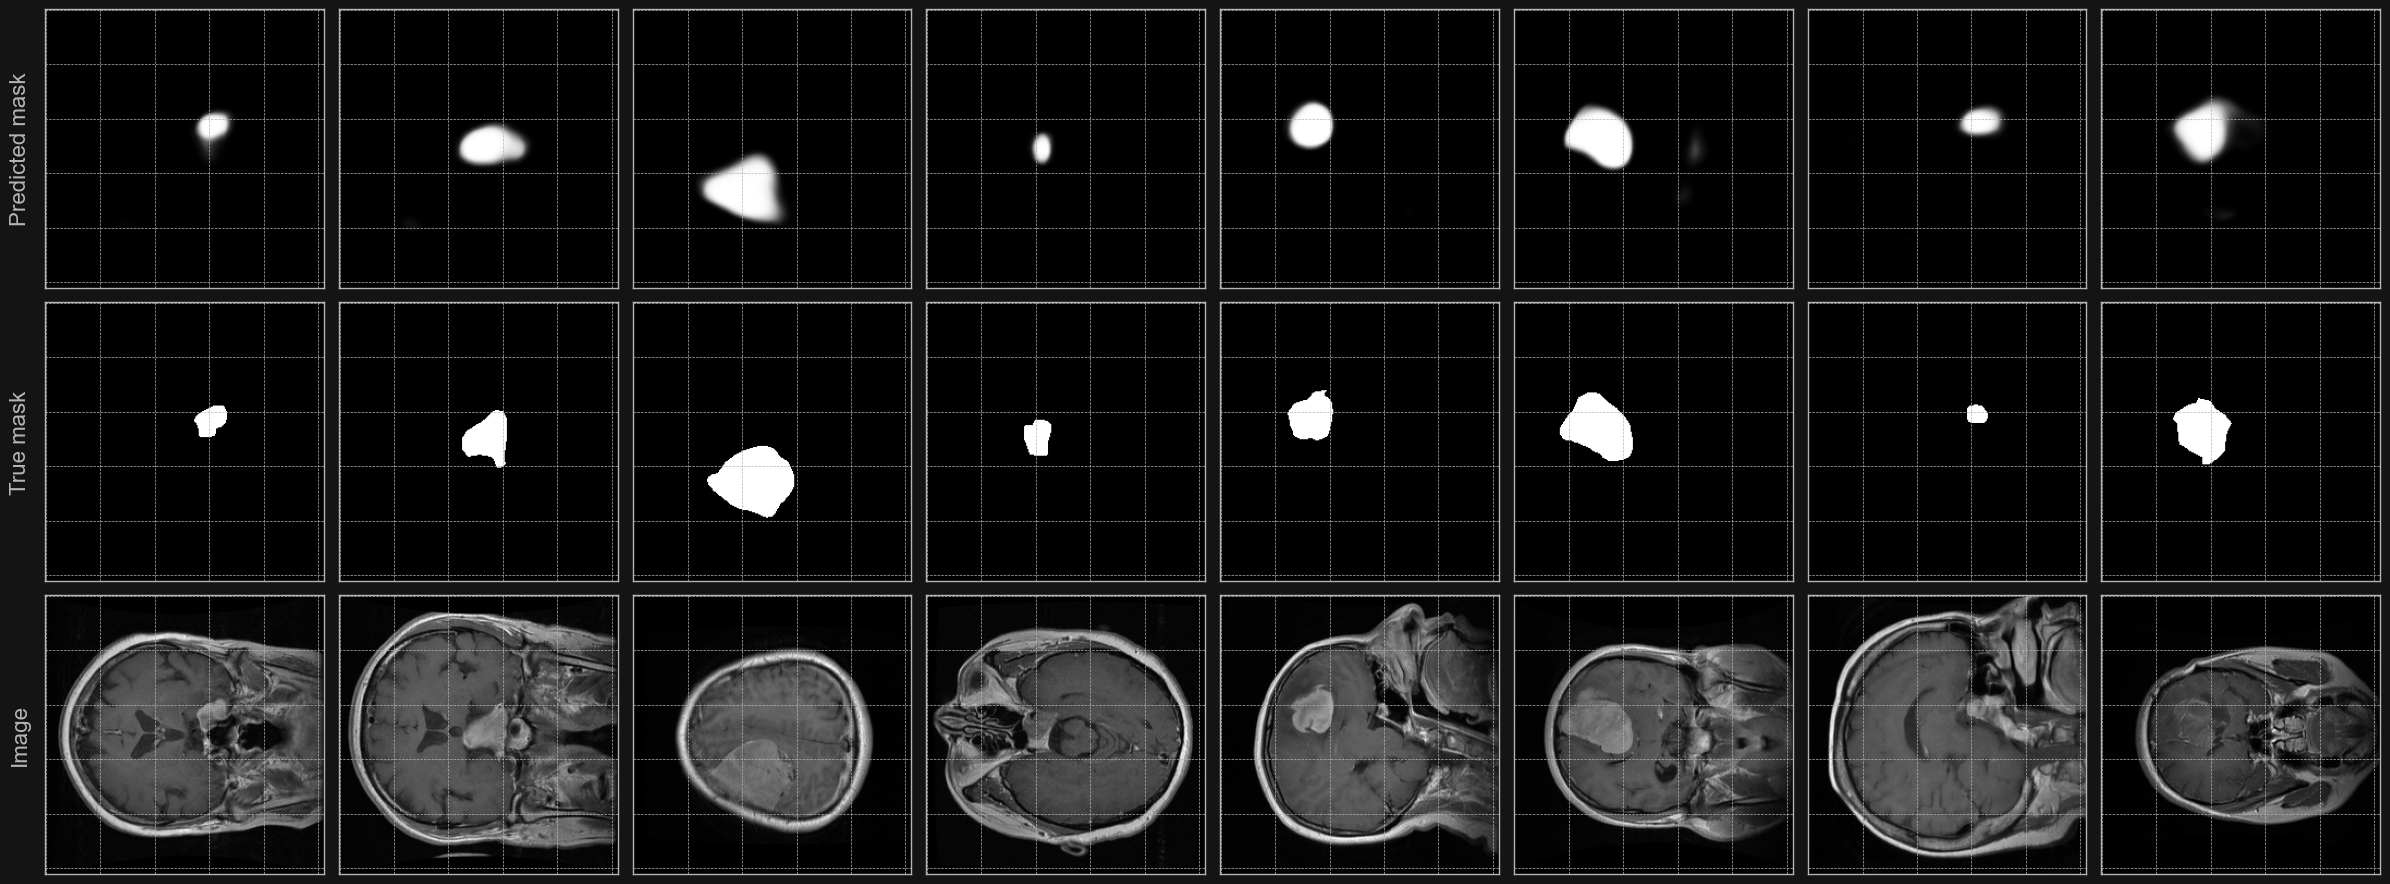

In [171]:
fig, axes = plt.subplots(nrows=3, ncols=8, figsize=(24, 9))
axes = axes.flatten()

for i in range(24):
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])

for i in range(8):
    axes[i].imshow(y_pred[i], cmap='gray')
    axes[i+8].imshow(y_true[i], cmap='gray')
    axes[i+16].imshow(x_true[i], cmap='gray')

axes[0].set_ylabel('Predicted mask', size=16)
axes[8].set_ylabel('True mask', size=16)
axes[16].set_ylabel('Image', size=16)

plt.tight_layout()

# V Conclusion
#### Tumor type classification
We ended up with decent F1 score of 95%. Despite this fact, model still have small problem with classifying _meningioma_ class, propably because of it's size.<br>
Note that the dataset itself is very good quality, it's balanced in terms of specific factors like: resolution, color range, object placement.<br><br>
#### Tumor location prediction
The training process takes way longer comparing to 1st model. However we can eventually increase the number of epochs to achieve better results.<br>
Honestly I don't think that's necessary.<br><br>
#### Significant improvement noticed after:
- Tweaking learning rate of the Adam optimizer
- Weighting classes
- Adding dropout layers for each convolution layer
<br>
instead of holding one dropout layer before output densing layers.
<br><br>
#### Ideas to improve:
- Preprocessing images with kmeans color clustering, didn't returned better results.
- Removing small images (head size), <br>
this meant to remove images where the number of black pixels exceeded a certain %.
<br><br>

Overall I think this is a good starting point to create some kind of application for brain MRI scans. It'd predict tumor type and it's location.<br><br>
#### Thanks for reading, I hope you enjoyed the analysis :] <br>
_Gracjan Pawłowski, 2024_